In [1021]:

import numpy as np
import matplotlib.pyplot as plt
import math 
import bisect
from collections import defaultdict
from typing import List

# Rejection sampling

In this worksheet you'll be doing the following tasks:

1. Define a function to sample from a discrete distribution.
2. Define classes for continuous and discrete random variables (provided).
3. Define a function to sample from a mixture distribution.
4. Define a rejection sampling function.
5. Test your functions on some examples.  

After this assignment, we'll extract this code into a separate module and keep importing it in the future assignments.

## Discrete distribution

1. To start with, copy your `RNG` class from the previous assignment below. Make sure to delete the unimplemented `mixture` method if one still exists there.
2. Also, the method `np.random.random()` returns a single random number (and not a list with a single element). Make sure this is the same behavior in your `RNG` class for all the sampling methods. If you simply called the method `self.uniform` and used list comprehension you should be fine. If you wrote your own loop then make sure to return a single number and not a list with a single element if `size=None` (not when `size=1`). I ran into this issue when testing my code. 
3. Then define a method `discrete` in the `RNG` class that takes a list of (unnormalized) probabilities and a list of values and returns a random sample from the corresponding discrete distribution. For example, if the input is `weights= [2, 8]` and `list=[3, 5]` then the output should be `3` with probability `0.2` and `5` with probability `0.8`.

In [1022]:

class RNG:
    def __init__(self, seed=None):
        self._rng = np.random.default_rng(seed)
        self.random = self._rng.random
    
    def seed(self, seed=None):
        self._rng = np.random.default_rng(seed)
    
    def uniform(self, low=0.0, high=1.0, size=None):
        return low + (high - low) * self.random(size)
    
    # choose a random object from a list
    def choice(self, list_, size=None):
        u = self.random(size)
        return list_[np.floor(u * len(list_)).astype(int)]
    
    def discrete(self, weights, list_=None, size=None):
        total_weight = sum(weights)
        intervals = np.cumsum(weights) / total_weight
        u_samples = self.random(size)
        return [list_[bisect.bisect_left(intervals, s)] for s in u_samples]
    
    def bernoulli(self, p=0.5, size=None):
        assert 0 <= p <= 1, "p must be between 0 and 1"
        u = self.random(size)
        return (u < p).astype(int)
        
    def binomial(self, n=1, p=0.5, size=None):
        assert 0 <= p <= 1, "p must be between 0 and 1"
        sample = lambda x, y: np.sum(self.bernoulli(x, y))
        return np.array([sample(p, n) for _ in range(size)])
    
    def exponential(self, lambda_=1.0, size=None):
        assert lambda_ > 0, "lambda must be positive"
        return -1/lambda_ * np.log(1 - self.uniform(size=size))
    
    def normal(self, mean=0.0, std=1.0, size=None):
        R = np.sqrt(-2 * np.log(1 - self.uniform(size=size))) # u1
        Theta = 2 * np.pi * self.uniform(size=size) # u2
        return mean + std * R * np.cos(Theta) # element-wise multiplication
        
    def poisson(self, lambda_=1.0, size=None):
        assert lambda_ > 0, "lambda must be positive"
        samples = np.zeros(size)
        for i in range(size):
            N, sum = 0, 0
            while True:
                X = self.exponential(lambda_, size=1)
                sum += X
                if sum > 1:
                    break
                N += 1
            samples[i] = N
        return samples

    def beta(self, a=1.0, b=1.0, size=None):
        assert a > 0 and b > 0, "a and b must be positive"
        assert isinstance(a, int) and isinstance(b, int), "a and b must be integers for this specific implementation"
        k, n = a, b + a - 1
        samples = np.array([self.uniform(size=n) for _ in range(size)])
        samples.sort(axis=1)
        return np.array([row[k-1] for row in samples])


    def triangular(self, low=0.0, high=1.0, mode=None, size=None):
        assert low <= mode <= high, "low <= mode <= high"
        samples = self.uniform(size=size)
        samples.sort()
        crit = (mode - low) / (high - low)
        return np.where(
            samples < crit, 
            low + np.sqrt(samples * (high - low) * (mode - low)), 
            high - np.sqrt((1 - samples) * (high - low) * (high - mode))
            )

    def weibull(self, shape=1.0, scale=1.0, size=None):
        assert shape > 0, "shape must be positive"
        assert scale > 0, "scale must be positive"
        return scale * (-np.log(1 - self.uniform(size=size)))**(1/shape)
    
rng = RNG()

## Test your discrete sampling function

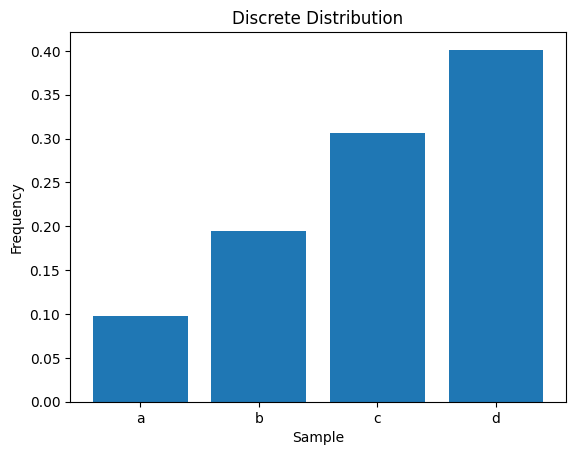

In [1023]:
# test discrete distribution
rng.seed(0)
size = 10000

samples = rng.discrete(weights=[0.1, 0.2, 0.3, 0.4], list_=['a', 'b', 'c', 'd'], size=size)
unique, counts = np.unique(samples, return_counts=True)
frequencies = counts / len(samples)

epsilon = 0.001 # allowance for floating point errors
assert abs(np.sum(frequencies) - 1) < epsilon, "Probabilities do not sum to 1"

# check that the samples are generated correctly
plt.bar(unique, frequencies)
plt.xlabel('Sample')
plt.ylabel('Frequency')
plt.title('Discrete Distribution')
plt.show()

## Continuous random variables

Below we define classes for continuous random variables that bundle the sampling methods together with the density functions. For now we only define the `pdf` method but for a full implementation we would need many more methods such as `cdf`, `ppf`, `mean`, `var`, etc. See the documentation of `scipy.stats.norm` class for an example. These classes are provided for you and you don't need to do anything with them. You can move on to the `Mixture` class.

In [1024]:
class RandomVariable():
    def __init__(self, rng):
        self.rng = rng
        
    def pdf(self, x):
        raise NotImplementedError
    
    def rsv(self, size=None):
        raise NotImplementedError

class Uniform(RandomVariable):
    def __init__(self, rng, low=0.0, high=1.0):
        super().__init__(rng)
        self.low = low
        self.high = high
        
    def rsv(self, size=None):
        return np.array(self.rng.uniform(low=self.low, high=self.high, size=size))

    def pdf(self, x):
        return np.array(np.where((x >= self.low) & (x <= self.high), 1 / (self.high - self.low), 0))
    
class Beta(RandomVariable):
    def __init__(self, rng, a=1.0, b=1.0):
        if not isinstance(a, int) or not isinstance(b, int):
            raise ValueError("a and b must be integers")
        super().__init__(rng)
        self.a = a
        self.b = b
        
    def rsv(self, size=None):
        return np.array(self.rng.beta(a=self.a, b=self.b, size=size))

    def pdf(self, x):
        return np.array(x**(self.a - 1) * (1 - x)**(self.b - 1) / self.beta(self.a, self.b))
    
    def beta(self, a, b):
        return math.factorial(a - 1) * math.factorial(b - 1) / math.factorial(a + b - 1)

class Exponential(RandomVariable):
    def __init__(self, rng, lambda_=1.0):
        super().__init__(rng)
        self.lambda_ = lambda_
        
    def rsv(self, size=None):
        return np.array(self.rng.exponential(lambda_=self.lambda_, size=size))

    def pdf(self, x):
        return np.array(self.lambda_ * np.exp(-self.lambda_ * x))

class Normal(RandomVariable):
    def __init__(self, rng, mean=0.0, std=1.0):
        super().__init__(rng)
        self.mean = mean
        self.std = std
        
    def rsv(self, size=None):
        return np.array(self.rng.normal(mean=self.mean, std=self.std, size=size))

    def pdf(self, x):
        return np.array(np.exp(-0.5 * ((x - self.mean) / self.std)**2) / np.sqrt(2 * np.pi * self.std**2))
    
class Bernoulli(RandomVariable):
    def __init__(self, rng, p=0.5):
        super().__init__(rng)
        self.p = p
        
    def rsv(self, size=None):
        return np.array(self.rng.bernoulli(p=self.p, size=size))

    def pdf(self, x):
        return np.array(np.where(x == 1, self.p, 1 - self.p))
    
class Poisson(RandomVariable):
    def __init__(self, rng, lambda_=1.0):
        super().__init__(rng)
        self.lambda_ = lambda_
        
    def rsv(self, size=None):
        return np.array(self.rng.poisson(lambda_=self.lambda_, size=size))

    def pdf(self, x):
        return np.array(self.lambda_**x * np.exp(-self.lambda_) / math.factorial(x))
    
class Binomial(RandomVariable):
    def __init__(self, rng, n=1, p=0.5):
        super().__init__(rng)
        self.n = n
        self.p = p
        
    def rsv(self, size=None):
        return np.array(self.rng.binomial(n=self.n, p=self.p, size=size))

    def pdf(self, x):
        return np.array(math.factorial(self.n) / (math.factorial(x) * math.factorial(self.n - x)) * self.p**x * (1 - self.p)**(self.n - x))
    
class Weibull(RandomVariable):
    def __init__(self, rng, shape=1.0, scale=1.0):
        super().__init__(rng)
        self.shape = shape
        self.scale = scale
        
    def rsv(self, size=None):
        return np.array(self.rng.weibull(shape=self.shape, scale=self.scale, size=size))

    def pdf(self, x):
        return np.array((self.shape / self.scale) * (x / self.scale)**(self.shape - 1) * np.exp(-(x / self.scale)**self.shape))
    
class Triangular(RandomVariable):
    def __init__(self, rng, low=0.0, high=1.0, mode=None):
        super().__init__(rng)
        self.low = low
        self.high = high
        self.mode = mode if mode else (low + high) / 2
        
    def rsv(self, size=None):
        return np.array(self.rng.triangular(low=self.low, high=self.high, mode=self.mode, size=size))

    def pdf(self, x):
        return np.array(np.where((x >= self.low) & (x < self.mode),
                                 2 * (x - self.low) / ((self.high - self.low) * (self.mode - self.low)),
                                 2 * (self.high - x) / ((self.high - self.low) * (self.high - self.mode))))
    
class Discrete(RandomVariable):
    def __init__(self, rng, weights, list_=None):
        super().__init__(rng)
        self.weights = weights
        self.list_ = list_
        
    def rsv(self, size=None):
        return np.array(self.rng.discrete(weights=self.weights, list_=self.list_, size=size))

    def pdf(self, x):
        return np.array(self.weights[self.list_.index(x)])

## Mixture Distribution

Next, define a class `Mixture` that takes a list of weights and a list of component random variables. The class should have a method `rsv` that samples a random variable from the mixture distribution and a method `pdf` that evaluates the density function of the mixture distribution.
Wrap your `rsv` output in a `np.array` (see above) to make sure it is a numpy array as `numpy` functions do not work well with lists.

In [1025]:
class Mixture(RandomVariable):
    def __init__(self, rng, weights, components: List[RandomVariable]):
        assert len(weights) == len(components), "weights and components must have the same length"
        super().__init__(rng)
        self.weights = weights
        self.components = components
    
    def rsv(self, size=None):
        sampled_components = Discrete(self.rng, self.weights, self.components).rsv(size=size)
        return np.array([comp.rsv() for comp in sampled_components])

    def pdf(self, x):
        return np.array(sum([w * c.pdf(x) for w, c in zip(self.weights, self.components)]))

## Test your mixture distribution

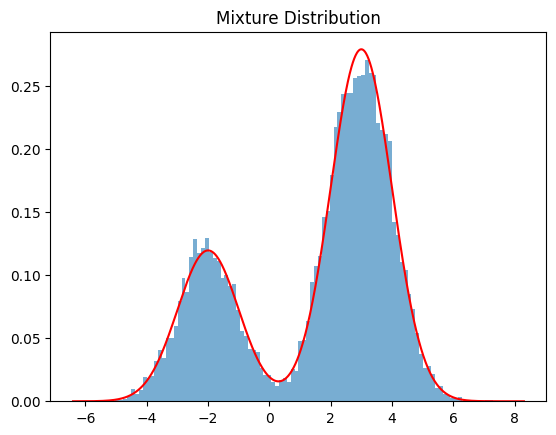

In [1026]:
# test mixture of normals
rng.seed(0)
size = 10000

normal1 = Normal(rng, mean=-2, std=1)
normal2 = Normal(rng, mean=3, std=1)

mixture = Mixture(rng, weights=[0.3, 0.7], components=[normal1, normal2])

samples = mixture.rsv(size=size)

# histogram of mixture distribution
plt.hist(samples, bins=math.floor(np.sqrt(size)), density=True, alpha=0.6)
plt.title('Mixture Distribution')

# plot scaled pdf of mixture distribution
x = np.linspace(samples.min() - 1, samples.max() + 1, 1000)
plt.plot(x, mixture.pdf(x), "red")
plt.show()

## Rejection sampler

In this section, you will implement and test a rejection sampling algorithm to generate samples from a target distribution using a proposal distribution. The rejection sampling algorithm will be implemented in the function `rejection_rsv`.

- Inputs:
  - `target_pdf`: The probability density function (pdf) of the target distribution (can be unnormalized).
  - `proposal_rv`: An instance of a continuous random variable class used as the proposal distribution. You will need to use both the `pdf` and `rsv` methods of this class.
  - `majorizing_constant`: A constant `M` such that `M * proposal_rv.pdf(x)` majorizes `target_pdf(x)` for all `x`.
  - `size`: The number of samples to generate.
- Outputs:
  - `samples`: An `ndarray` of samples from the target distribution.
  - `efficiency`: The proportion of samples that were accepted.

Note that `size` is the number of samples to accept, not the number of samples to generate. You will need to generate more samples than `size` to ensure that you accept `size` samples.

In [1027]:
def rejection_rsv(target_pdf, proposal_rv: RandomVariable, majorizing_constant, size):
  rng = RNG()
  accept = []
  trials = 0
  U = Uniform(rng, 0, 1)
  while len(accept) < size:
    x = proposal_rv.rsv(1)
    u = U.rsv(None)
    if u <= target_pdf(x) / (majorizing_constant * proposal_rv.pdf(x)):
      accept.append(x)
    trials += 1
  efficiency = size / trials
  return np.array(accept), efficiency

## Test 1

Test your algorithm on a truncated standard normal distribution. Use a uniform distribution to majorize the target distribution. A sample code is provided below. Fill in the appropriate constants. Feel free to find the majorizing constant by trial and error.

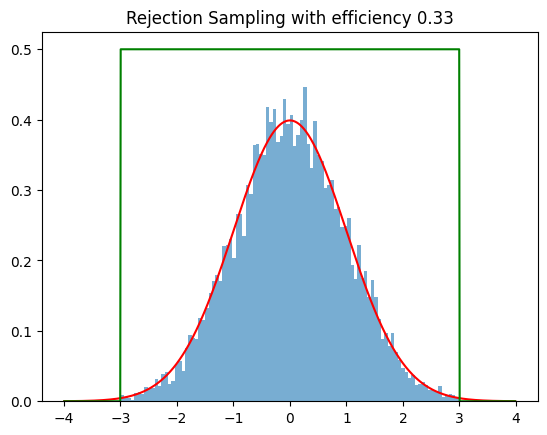

In [1028]:
# test rejection_rsv for normal distribution
# find appropriate values of low, high, and M
rng.seed(0)
size = 10000

target_pdf = Normal(rng, mean=0, std=1).pdf
proposal = Uniform(rng, low=-3, high=3)

M = 3

samples, efficiency = rejection_rsv(target_pdf, proposal, M, size)

assert len(samples) == size, "Incorrect number of samples"

# histogram of samples
plt.hist(samples, math.floor(math.sqrt(size)), density=True, alpha=0.6)
plt.title('Rejection Sampling with efficiency {:.2f}'.format(efficiency))

# plot scaled pdf of target distribution
x = np.linspace(samples.min() - 1, samples.max() + 1, 1000)
plt.plot(x, target_pdf(x), "red")
plt.plot(x, M*proposal.pdf(x), "green")

plt.show()

## Test 2

Next see what happens if you choose a value of `M` that is too small, say less than half the height of peak of the target distribution. 

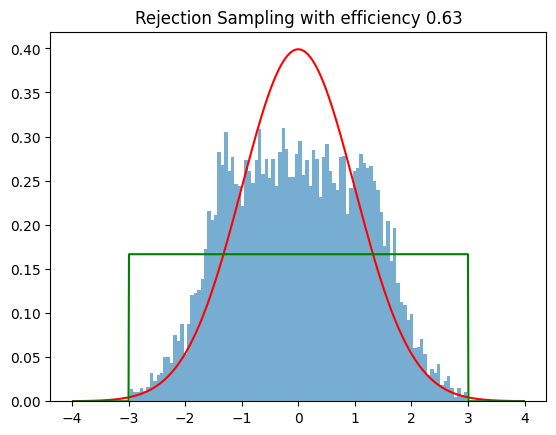

In [1029]:
# test rejection_rsv for normal distribution
# find appropriate values of low, high, and M
rng.seed(0)
size = 10000

target_pdf = Normal(rng, mean=0, std=1).pdf
proposal = Uniform(rng, low=-3, high=3)

M = 1

samples, efficiency = rejection_rsv(target_pdf, proposal, M, size)

assert len(samples) == size, "Incorrect number of samples"

# histogram of samples
plt.hist(samples, math.floor(math.sqrt(size)), density=True, alpha=0.6)
plt.title('Rejection Sampling with efficiency {:.2f}'.format(efficiency))

# plot scaled pdf of target distribution
x = np.linspace(samples.min() - 1, samples.max() + 1, 1000)
plt.plot(x, target_pdf(x), "red")
plt.plot(x, M*proposal.pdf(x), "green")

plt.show()

# our distribution flattens out where the majorizing function is too low

## Test 3

Test your algorithm on a (truncated) mixture of a normal distributions. Use a uniform distribution to majorize the target distribution. This time write your own code. The final graph should show the target distribution, the scaled proposal distribution, and a histogram of the samples.

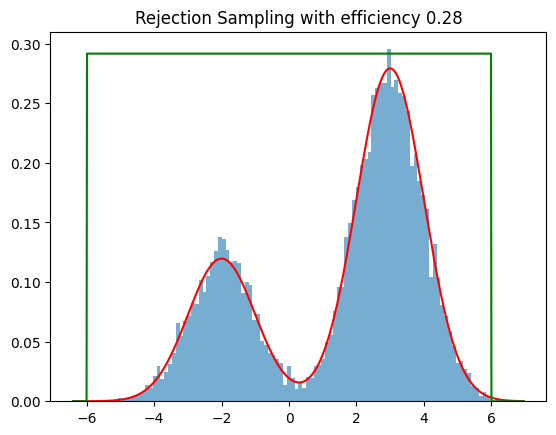

In [1030]:
# test rejection rsv
rng.seed(0)
size = 10000

normal1 = Normal(rng, mean=-2, std=1)
normal2 = Normal(rng, mean=3, std=1)

mixture = Mixture(rng, weights=[0.3, 0.7], components=[normal1, normal2])

target_pdf = mixture.pdf
proposal = Uniform(rng, low=-6, high=6)

M = 3.5

samples, efficiency = rejection_rsv(target_pdf, proposal, M, size)

assert len(samples) == size, "Incorrect number of samples"

# histogram of samples
plt.hist(samples, math.floor(math.sqrt(size)), density=True, alpha=0.6)
plt.title('Rejection Sampling with efficiency {:.2f}'.format(efficiency))

# plot scaled pdf of target distribution
x = np.linspace(samples.min() - 1, samples.max() + 1, 1000)
plt.plot(x, target_pdf(x), "red")
plt.plot(x, M*proposal.pdf(x), "green")

plt.show()


## Test 4

Finally, test your algorithm on a (truncated) mixture of a normal distributions. Use a mixture of two or more uniform distributions to majorize the target distribution. Compare the efficiency of the algorithm to the one above.

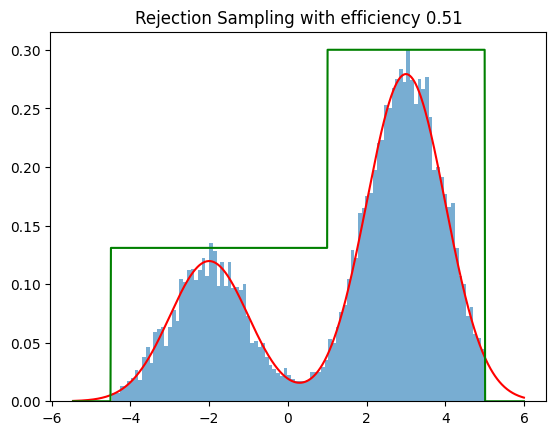

In [1031]:
# test rejection rsv
rng.seed(0)
size = 10000

normal1 = Normal(rng, mean=-2, std=1)
normal2 = Normal(rng, mean=3, std=1)

mixture = Mixture(rng, weights=[0.3, 0.7], components=[normal1, normal2])

target_pdf = mixture.pdf

uniform1 = Uniform(rng, low=-4.5, high=1)
uniform2 = Uniform(rng, low=1, high=5)
proposal = Mixture(rng, weights=[1.2, 2], components=[uniform1, uniform2])

M = 0.6

samples, efficiency = rejection_rsv(target_pdf, proposal, M, size)

assert len(samples) == size, "Incorrect number of samples"

# histogram of samples
plt.hist(samples, math.floor(math.sqrt(size)), density=True, alpha=0.6)
plt.title('Rejection Sampling with efficiency {:.2f}'.format(efficiency))

# plot scaled pdf of target distribution
x = np.linspace(samples.min() - 1, samples.max() + 1, 1000)
plt.plot(x, target_pdf(x), "red")
plt.plot(x, M*proposal.pdf(x), "green")

plt.show()

# we have a higher efficiency here
